In [19]:
%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, t, kstest
from sklearn.linear_model import Lasso
import statsmodels.api as sm
np.random.seed(0)


In [20]:

n_samples = 500
n_features = 5       
iter = 3000  
lam = 0.1
true_beta = np.zeros(n_features)  
true_beta[0] = 5
true_beta[1] = -3
std_noise = 10

X = np.random.normal(0, 1, size=(n_samples, n_features))


def create_data(X, true_beta, intercept, std_noise):
    n = X.shape[0]
    linear_component = X @ true_beta
    noise = np.random.normal(0, std_noise, size = n)
    y = linear_component + noise + intercept
    return y


def fit_lasso_model_sklearn(X, y, lam):
    model = Lasso(alpha=lam, fit_intercept=True, tol=1e-4, max_iter=2000)
    model.fit(X, y)
    return model.coef_, model.intercept_

def fit_lasso_model(X, y, lam, max_iter = 7000, tol = 1e-5):
    def soft_thresolding(rho, lam, z):
        if rho < -lam:
            return (rho + lam)/z
        elif rho > lam:
            return (rho - lam)/z
        else:
            return 0
    n, p = X.shape
    beta = np.random.uniform(size = p)
    residual = y - X @ beta
    intercept = 0
    for iter in range(max_iter):
        beta_old = beta.copy()
        intercept_old = intercept
        for j in range(p):
            r_j = residual + X[:, j] * beta[j]
            rho = 1/n * X[:, j].T @ r_j
            z = 1/n * (X[:, j] ** 2).sum()

            beta[j] = soft_thresolding(rho, lam, z)
            residual = r_j - X[:, j] * beta[j]
        if np.linalg.norm(beta - beta_old, ord=1) < tol and abs(intercept - intercept_old) < tol:
            break
        intercept = np.mean(y) - np.sum(np.mean(X, axis = 0) * beta) 
    return beta, intercept
beta_hat_list = [] 
p_values_lists = []
def calculating_p_values(X, y, beta_hat, intercept_hat):
    n, p = X.shape
    residual = y - X @ beta_hat - intercept_hat
    sigma_squared = (residual.T @ residual) / (n - p)
    var_beta_hat = sigma_squared * np.linalg.inv(X.T @ X)
    se_beta = np.sqrt(np.diag(var_beta_hat))
    t_stats = beta_hat.flatten() / se_beta
    p_values = 2 * (1 - t.cdf(np.abs(t_stats), df = n - p))
    return p_values
for i in range(iter):
    current_y =  create_data(X, true_beta, 2, std_noise)

    beta_hat, intercept_hat = fit_lasso_model(X, current_y, lam)
    p_value = calculating_p_values(X, current_y, beta_hat, intercept_hat)
    p_values_lists.append(p_value)
    beta_hat_list.append(np.concatenate([[intercept_hat], beta_hat]))

print(beta_hat_list[0][0].shape)
print(beta_hat_list[0][1].shape)
beta_hat_df = pd.DataFrame(beta_hat_list, columns = ['Intercept'] + [f'BetaX{i}' for i in range(n_features)])
print(beta_hat_df)
columns = beta_hat_df.columns
beta_true = np.concatenate([[2], true_beta])
pvalues_df = pd.DataFrame(p_values_lists, columns = [f'BetaX{i}' for i in range(n_features)])
p_columns = pvalues_df.columns


()
()
      Intercept    BetaX0    BetaX1    BetaX2    BetaX3    BetaX4
0      1.276870  5.181546 -3.255456  0.000000  0.099514  0.839058
1      1.484254  4.551331 -3.472262 -0.241887 -0.128599  0.045601
2      1.997462  4.489989 -2.355214  0.500074 -0.242931  0.086438
3      2.214807  4.716271 -2.195714  0.806147 -0.223642  0.642405
4      2.606425  4.249050 -2.534242  0.112857  0.402953  0.000000
...         ...       ...       ...       ...       ...       ...
2995   1.696401  4.757601 -2.561843  0.427254  0.000000  0.043285
2996   1.660514  4.862447 -2.356429 -0.542411 -0.097087 -0.191805
2997   1.944767  4.172984 -2.697792  0.310051  0.441224  0.186795
2998   1.316044  4.392723 -2.717762  0.043845 -0.094387  0.082003
2999   1.296941  4.209836 -3.396828 -0.562496 -0.161674  0.234665

[3000 rows x 6 columns]


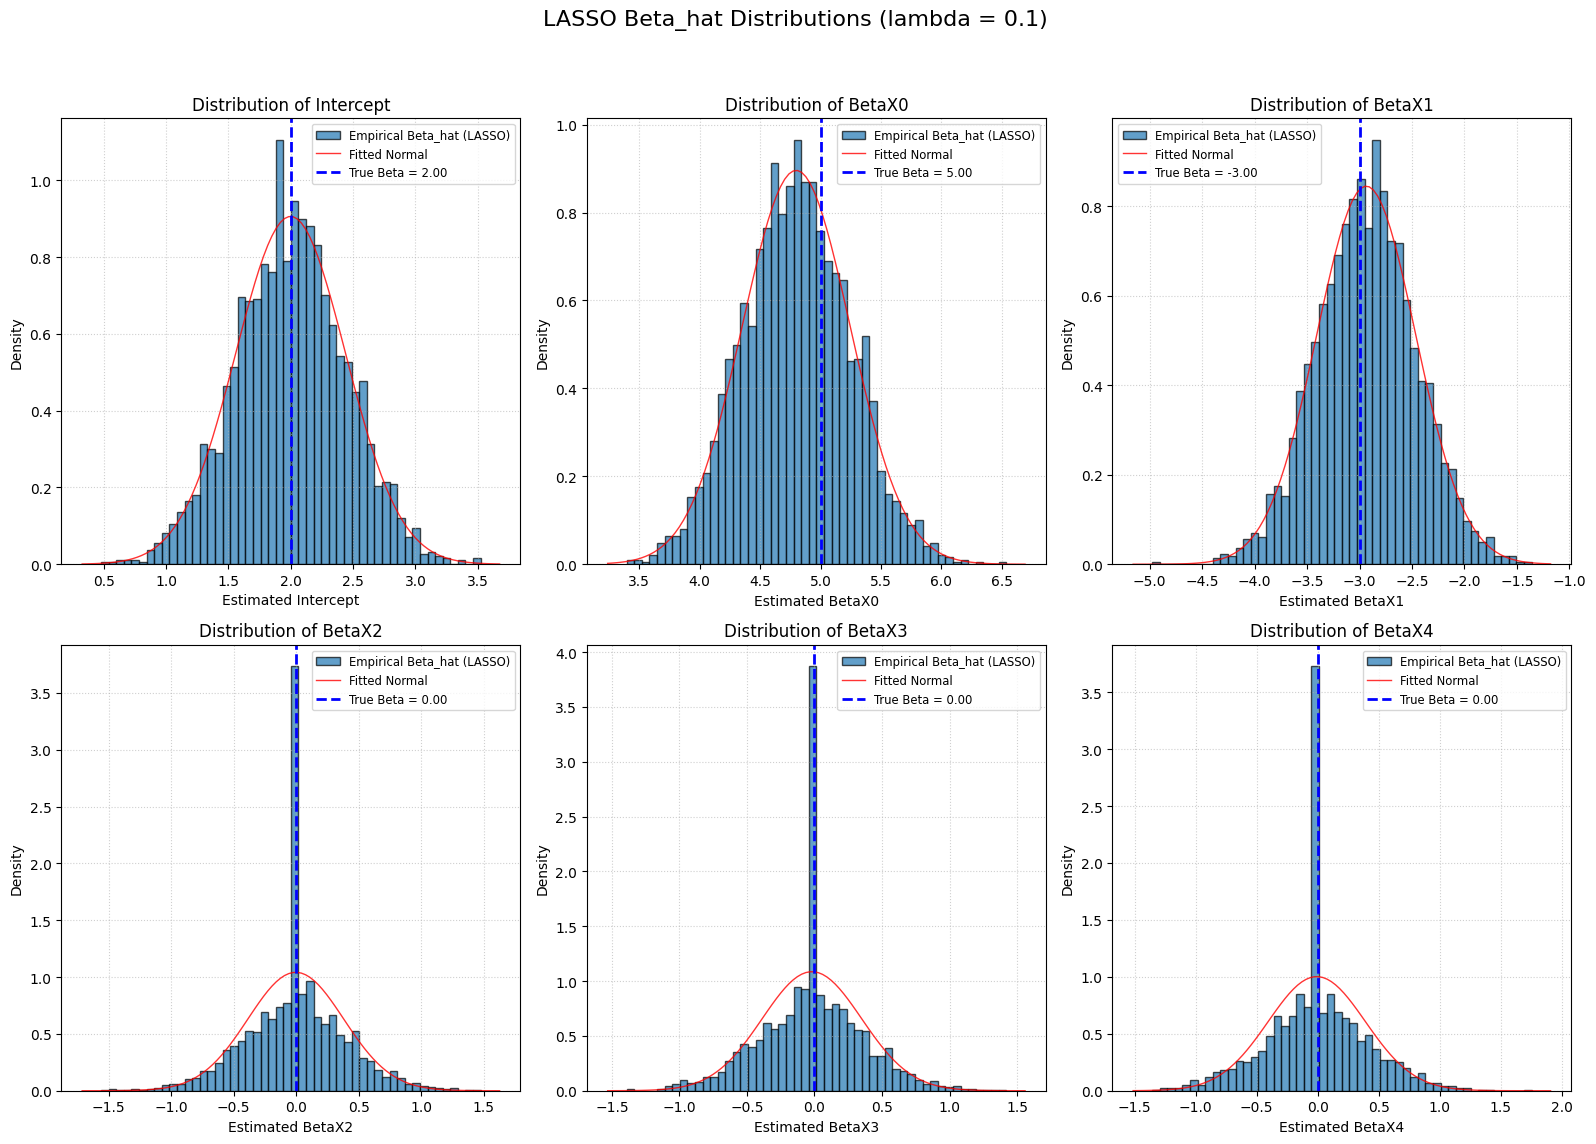

In [21]:
fig_b, axes_b = plt.subplots(2, 3, figsize=(16, 12))
axes_b = axes_b.flatten()


for idx, col_name in enumerate(columns):
    beta_values_for_hist = beta_hat_df[col_name]
    axes_b[idx].hist(beta_values_for_hist, bins=50, density=True, edgecolor='black', alpha=0.7, label='Empirical Beta_hat (LASSO)')
    
    mu_emp, std_emp = norm.fit(beta_values_for_hist)
    xmin_hist, xmax_hist = axes_b[idx].get_xlim()
    x_norm_emp = np.linspace(xmin_hist, xmax_hist, 100)
    p_norm_emp = norm.pdf(x_norm_emp, mu_emp, std_emp)
    axes_b[idx].plot(x_norm_emp, p_norm_emp, 'r-', linewidth=1, alpha=0.8, label=f'Fitted Normal')

    true_val_plot = beta_true[idx]
    axes_b[idx].axvline(true_val_plot, color='blue', linestyle='--', linewidth=2, label=f'True Beta = {true_val_plot:.2f}')
    
    axes_b[idx].set_title(f'Distribution of {col_name}')
    axes_b[idx].set_xlabel(f'Estimated {col_name}')
    axes_b[idx].set_ylabel('Density')
    axes_b[idx].legend(fontsize='small')
    axes_b[idx].grid(True, linestyle=':', alpha=0.6)

# Ẩn các subplot không sử dụng
for i in range(len(columns), len(axes_b)):
    fig_b.delaxes(axes_b[i])

fig_b.suptitle(f"LASSO Beta_hat Distributions (lambda = {lam})", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

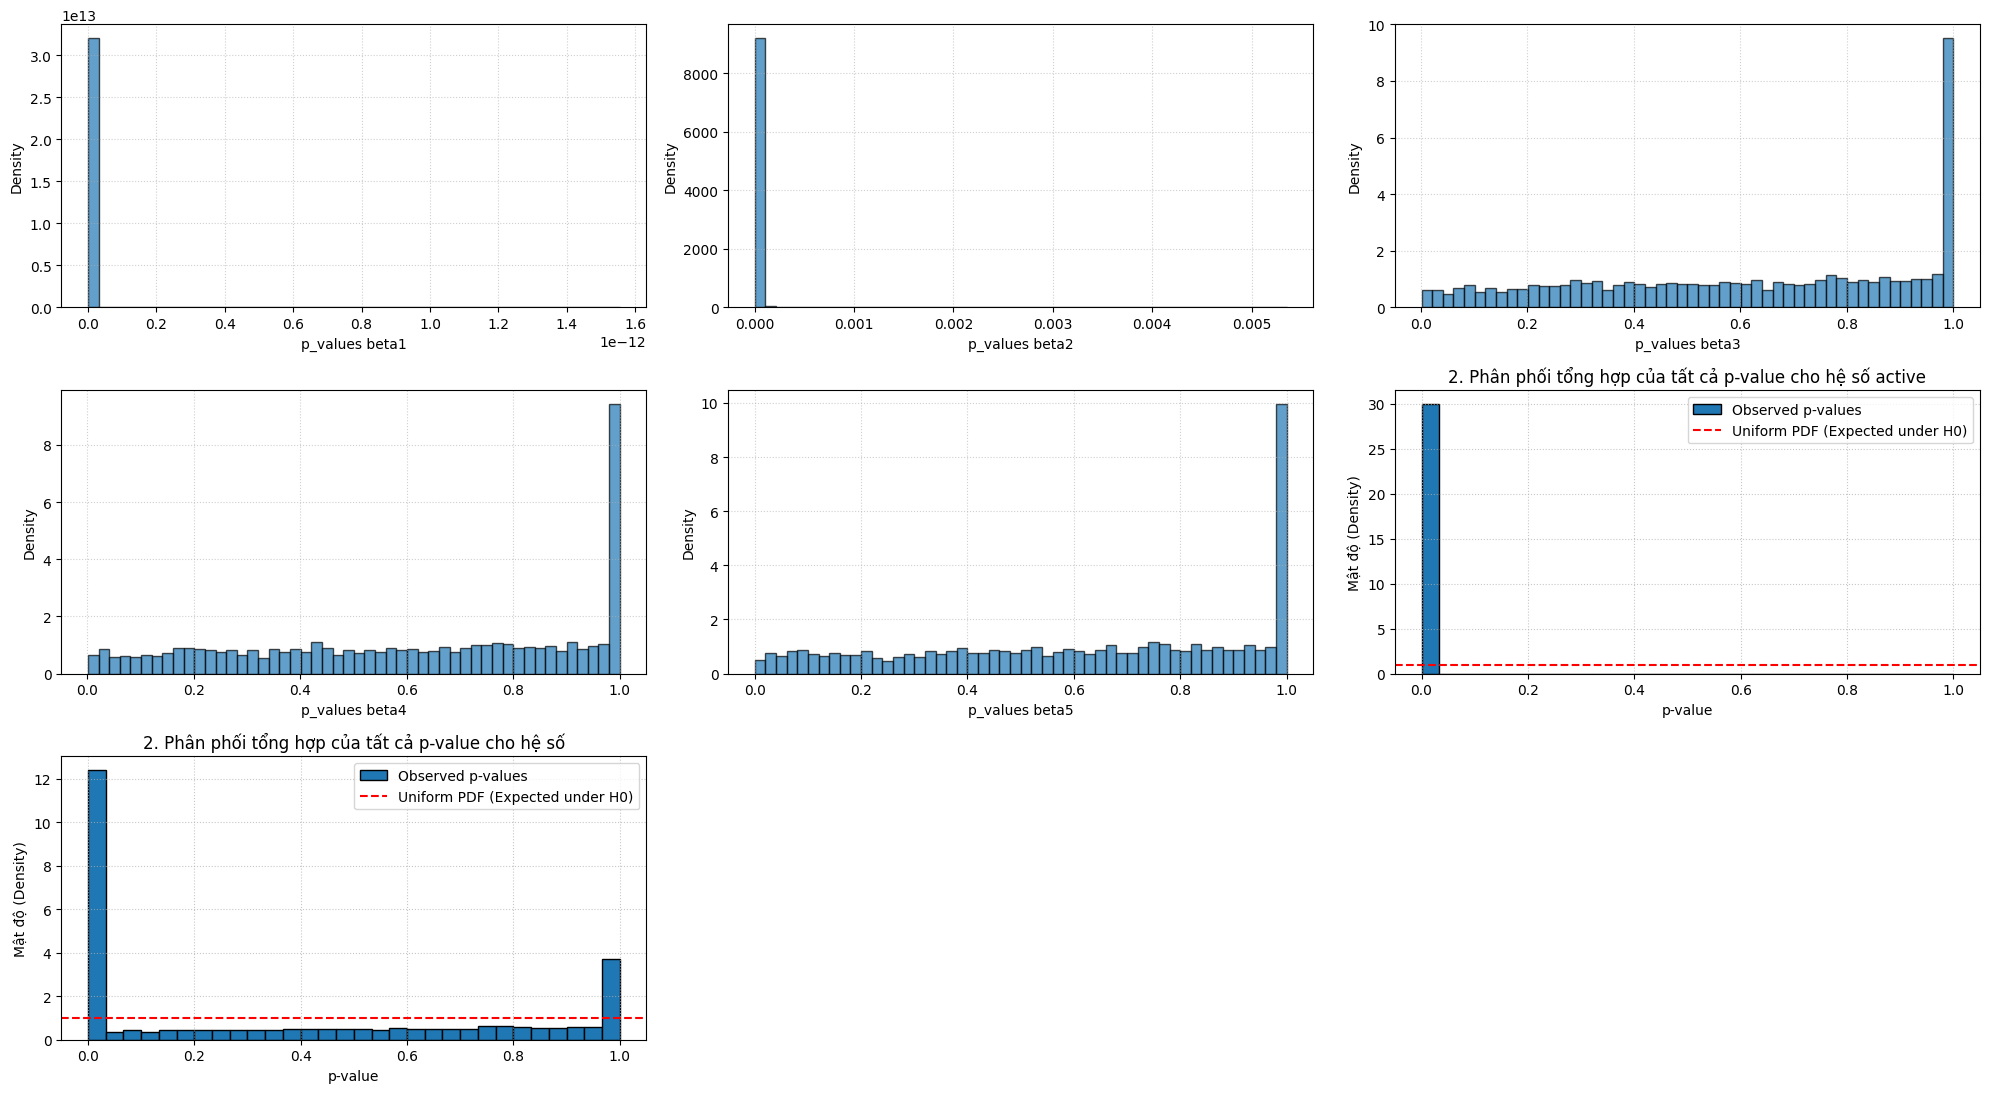

In [22]:
fig_b, axes_b = plt.subplots(3, 3, figsize = (20, 12))
axes_b = axes_b.flatten()


for idx, col_name in enumerate(p_columns):
    p_values = pvalues_df[col_name]
    axes_b[idx].hist(p_values, bins=50, density=True, edgecolor='black', alpha=0.7)
    
    axes_b[idx].set_xlabel(f'p_values beta{idx + 1}')
    axes_b[idx].set_ylabel('Density')
    axes_b[idx].grid(True, linestyle=':', alpha=0.6)

all_active_p_values = pvalues_df[p_columns[:2]].values.flatten()

axes_b[5].hist(all_active_p_values, bins=30, range=(0,1), density=True, edgecolor='black', label='Observed p-values')
axes_b[5].axhline(1, color='red', linestyle='--', label='Uniform PDF (Expected under H0)')
axes_b[5].set_title('2. Phân phối tổng hợp của tất cả p-value cho hệ số active')
axes_b[5].set_xlabel('p-value')
axes_b[5].set_ylabel('Mật độ (Density)')
axes_b[5].legend()
axes_b[5].grid(True, linestyle=':', alpha=0.7)


all_p_values = pvalues_df[p_columns].values.flatten()

axes_b[6].hist(all_p_values, bins=30, range=(0,1), density=True, edgecolor='black', label='Observed p-values')
axes_b[6].axhline(1, color='red', linestyle='--', label='Uniform PDF (Expected under H0)')
axes_b[6].set_title('2. Phân phối tổng hợp của tất cả p-value cho hệ số')
axes_b[6].set_xlabel('p-value')
axes_b[6].set_ylabel('Mật độ (Density)')
axes_b[6].legend()
axes_b[6].grid(True, linestyle=':', alpha=0.7)


plt.delaxes(axes_b[7])
plt.delaxes(axes_b[8])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [23]:
kstest(beta_hat_df['BetaX4'], 'norm', args=(np.mean(beta_hat_df['BetaX4']), np.std(beta_hat_df['BetaX4'])))


KstestResult(statistic=np.float64(0.09082717730324907), pvalue=np.float64(5.498061642268066e-22), statistic_location=np.float64(0.0011813266555220415), statistic_sign=np.int8(1))